# Link Level Simulation for Physical Downlink Control Channels

Link-level simulation in 5G networks involves simulating the Physical Downlink Control Channel (PDCCH), which is responsible for transmitting control information from the base station (gNB) to the user equipment (UE). PDCCH carries essential information such as resource allocation, scheduling assignments, and other control signaling necessary for UE communication and network operation.

In a link-level simulation of PDCCH, various parameters and characteristics of the channel are modeled and simulated to analyze the performance of the control channel under different conditions. This includes:

1. Channel Modeling: Simulating the radio channel characteristics, including path loss, fading, delay spread, and Doppler effects, to accurately represent the wireless propagation environment.

2. Modulation and Coding: Modeling the modulation and coding schemes (MCS) used for PDCCH transmission to evaluate the impact of different coding and modulation techniques on channel reliability and throughput.

3. Resource Allocation: Simulating the resource allocation process to assess how resources are assigned to UEs based on scheduling decisions made by the gNB.

4. Error Correction: Evaluating the effectiveness of error correction mechanisms such as Hybrid Automatic Repeat Request (HARQ) in recovering from transmission errors and improving overall reliability.

5. Interference Analysis: Analyzing the impact of interference from neighboring cells or other UEs on PDCCH reception and performance.

6. Beamforming and MIMO: Assessing the benefits of beamforming and Multiple Input Multiple Output (MIMO) techniques in enhancing PDCCH transmission and reception, especially in scenarios with high mobility or dense deployments.

Overall, link-level simulation of PDCCH in 5G networks provides valuable insights into the channel behavior, system performance, and optimization strategies for efficient control channel design and operation.

The flow of the tutorial as described as follows:

- [Import Libraries](#import-libraries)
    - [Import Basic Python Libraries](#Import-Basic-Python-Libraries)
    - [Import 5G-Toolkit Libraries](#Import-5G-Toolkit-Libraries)
- [Simulation Parameters](#Simulation-Parameters)
- [CORESET Parameters](#CORESET-Parameters)
- [Generate Wireless Channel: CDL-A](#Generate-Wireless-Channel:-CDL-A)
- [Link level Simulation: For each Aggregation level and Each SNR value](#Link-level-Simulation:-For-each-Aggregation-level-and-Each-SNR-value)
- [Reliability Performance: BER/BLER vs SNR](#Reliability-Performance:-BER/BLER-vs-SNR)
- [Reliability Performance: BER/BLER vs SNR for 20000 Batches](#Reliability-Performance:-BER/BLER-vs-SNR-for-20000-Batches)


## Import Libraries

### Import Basic Python Libraries

In [1]:
import numpy as np
import matplotlib as mpl

# %matplotlib widget
# %matplotlib inline
import matplotlib.pyplot  as plt
import matplotlib.patches as patches

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## Import 5G-Toolkit Libraries

In [2]:
import sys
sys.path.append("../../../")

from toolkit5G.PhysicalChannels   import PDCCH, PDCCHDecoder
from toolkit5G.ResourceMapping    import ResourceMappingPDCCH, CORESET
from toolkit5G.ReceiverAlgorithms import ChannelEstimationAndEqualizationPDCCH
from toolkit5G.ChannelModels      import AntennaArrays, SimulationLayout, ParameterGenerator, ChannelGenerator
from toolkit5G.ChannelProcessing  import AddNoise

## Simulation Parameters 

In [3]:
terrain          = "CDL-A"               # Propagation Scenario or Terrain for BS-UE links
carrierFrequency = 3.6*10**9             # carrier frequency in Hz
mu               = 0                     # numerology
scs              = (2**mu)*(15*10**3)    # sub-carrier spacing
slotNumber       = 0                     # slot number. Note that number of slots per sub-frame of 1 ms is 2**mu
numRBs           = 270                   # Please don't change this. The simulation will break down
Bandwidth        = numRBs*scs  
nBSs             = 1                     # number of BSs 
nUEs             = 1                     # number of UEs 
bsArrayGeometry  = np.array([1,1,1,2,2], dtype=int)
ueArrayGeometry  = np.array([1,1,1,1,2], dtype=int)
Nt               = bsArrayGeometry.prod() # number of Tx antenna
Nr               = ueArrayGeometry.prod() # number of Rx antenna
Nfft             = 4096
nBatches         = 200


## CORESET Parameters

In [4]:
AggLevel         = np.array([1,2,4,8,16], dtype=int)

monitoringSymbolsWithinSlot = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype = int)
startSymIndex               = np.nonzero(monitoringSymbolsWithinSlot)[0][0]

cce_reg_Mapping = "interleaved"               # CCE to REG mapping type
L = np.array([2,6,6,6,6], dtype=int)          # REG-bundle size for each Aggregation level
R = np.array([3,2,2,2,2], dtype=int)          # Interleaver size for each Aggregation level 
nshift = np.array([0,0,0,0,0], dtype=int)     # cyclic-shift index after interleaving

duration = np.array([1,1,2,2,2], dtype=int)   # duration of CORESET for each Aggregation level (AL)

fdr1 = np.array([1,0,0,0,0,0,0,0,0,
                 0,0,0,0,0,0,0,0,0,
                 0,0,0,0,0,0,0,0,0,
                 0,0,0,0,0,0,0,0,0,
                 0,0,0,0,0,0,0,0,0], dtype = int) # 1 one

fdr2 = np.array([1,1,0,0,0,0,0,0,0,
                 0,0,0,0,0,0,0,0,0,
                 0,0,0,0,0,0,0,0,0,
                 0,0,0,0,0,0,0,0,0,
                 0,0,0,0,0,0,0,0,0], dtype = int) # 2 ones

fdr4 = fdr2

fdr8 = np.array([1,1,1,1,0,0,0,0,0,
                 0,0,0,0,0,0,0,0,0,
                 0,0,0,0,0,0,0,0,0,
                 0,0,0,0,0,0,0,0,0,
                 0,0,0,0,0,0,0,0,0], dtype = int) # 4 ones

fdr16 = np.array([1,1,1,1,1,1,1,1,0,
                  0,0,0,0,0,0,0,0,0,
                  0,0,0,0,0,0,0,0,0,
                  0,0,0,0,0,0,0,0,0,
                  0,0,0,0,0,0,0,0,0], dtype = int) # 8 ones

frequencyDomainResources = np.array([fdr1,fdr2,fdr4,fdr8,fdr16], dtype=int) # freq Domain Resources for each AL


## Generate Wireless Channel: CDL-A

In [5]:
# Antenna Array at UE side
# assuming antenna element type to be "OMNI"
# with 2 panel and 2 single polarized antenna element per panel.
ueAntArray = AntennaArrays(antennaType = "OMNI",  centerFrequency = carrierFrequency, 
                           arrayStructure  = ueArrayGeometry)
ueAntArray() 

# # Radiation Pattern of Rx antenna element 
# ueAntArray.displayAntennaRadiationPattern()


# Antenna Array at BS side
# assuming antenna element type to be "3GPP_38.901", a parabolic antenna 
# with 4 panel and 4 single polarized antenna element per panel.
bsAntArray = AntennaArrays(antennaType = "3GPP_38.901", centerFrequency = carrierFrequency, 
                           arrayStructure  = bsArrayGeometry)
bsAntArray()
    
# # Radiation Pattern of Tx antenna element 
# bsAntArray[0].displayAntennaRadiationPattern()

# Layout Parameters
isd                  = 200         # inter site distance
minDist              = 10          # min distance between each UE and BS 
ueHt                 = 1.5         # UE height
bsHt                 = 25          # BS height
bslayoutType         = "Hexagonal" # BS layout type
ueDropType           = "Hexagonal" # UE drop type
htDist               = "equal"     # UE height distribution
ueDist               = "equal"     # UE Distribution per site
nSectorsPerSite      = 1           # number of sectors per site
maxNumFloors         = 1           # Max number of floors in an indoor object
minNumFloors         = 1           # Min number of floors in an indoor object
heightOfRoom         = 3           # height of room or ceiling in meters
indoorUEfract        = 0.5         # Fraction of UEs located indoor
lengthOfIndoorObject = 3           # length of indoor object typically having rectangular geometry 
widthOfIndoorObject  = 3           # width of indoor object
forceLOS             = False       # boolen flag if true forces every link to be in LOS state

# simulation layout object                                 
simLayoutObj = SimulationLayout(numOfBS = nBSs,
                                numOfUE = nUEs,
                                heightOfBS = bsHt,
                                heightOfUE = ueHt,
                                minUEBSDistance = minDist,
                                ISD = isd,
                                layoutType = bslayoutType,
                                ueDropMethod = ueDropType, 
                                UEdistibution = ueDist,
                                UEheightDistribution = htDist,
                                numOfSectorsPerSite = nSectorsPerSite,
                                ueRoute = None)

simLayoutObj(terrain = terrain, carrierFreq = carrierFrequency, 
             ueAntennaArray = ueAntArray, bsAntennaArray = bsAntArray,
             indoorUEfraction = indoorUEfract,
             lengthOfIndoorObject = lengthOfIndoorObject,
             widthOfIndoorObject  = widthOfIndoorObject, forceLOS = forceLOS)



paramGen = simLayoutObj.getParameterGenerator()

# paramGen.displayClusters((0,0,0), rayIndex = 0)
channel = paramGen.getChannel()
Hf      = channel.ofdm(scs, Nfft, normalizeChannel = True)[0,0,0]

print(" Hf shape: "+str(Hf.shape)) #(nUEs,Nfft, Nr, Nt) 

 Hf shape: (1, 4096, 2, 4)


## Link level Simulation: For each Aggregation level and Each SNR value

In [6]:
numPoints  = 10
SNRdB      = np.array([np.linspace(-5, 10, numPoints),
                       np.linspace(-7, 7, numPoints),
                       np.linspace(-10, 5, numPoints),
                       np.linspace(-15, 3, numPoints),
                       np.linspace(-15, 1, numPoints)])

SNR        = 10**(SNRdB/10)

codedBER   = np.zeros((AggLevel.size, numPoints))
uncodedBER = np.zeros((AggLevel.size, numPoints))
bler       = np.zeros((AggLevel.size, numPoints))

rnti       = int(1 + np.random.randint(65518, dtype = int)) # rnti
nID        = int(np.random.randint(65536, dtype = int))     # scrambling-ID from scrambling ratematched Bits
bwpOffset  = 0

for al in range(AggLevel.size):
    print("##############################################################")
    print("Simulation: ["+str(al)+"] for    AL = "+str(AggLevel[al]))
    coresetObj        = CORESET(duration[al],frequencyDomainResources[al])
    coresetPRBIndices = coresetObj(cce_REG_MappingType = cce_reg_Mapping, 
                                   reg_BundleSize=L[al], interleaverSize = R[al], shiftIndex = nshift[al])
    numPDCCHsymbols  = int(54*AggLevel[al]) # number of REs occupied by PDCCH data (QPSK symbols)
    numPDCCHdmrs     = int(18*AggLevel[al]) # number of REs occupied by PDCCH DMRS symbols
    chosenCCEindices = np.arange(AggLevel[al])

    E        = numPDCCHsymbols*2   # number of target Bits
    K        = 20                  # payload size in bits
    dciBits  = np.random.randint(0, 2, [nBatches, K]) 


    pdcch = PDCCH(K, E, rnti, nID)
    symb  = pdcch(dciBits)


    rmPDCCH      = ResourceMappingPDCCH(mu, frequencyDomainResources[al], duration[al], monitoringSymbolsWithinSlot)
    resGrid      = rmPDCCH(symb, cce_reg_Mapping, L[al], R[al], nshift[al], slotNumber, nID, chosenCCEindices)
    numRBs       = int(resGrid.shape[-1]/12)
    numSymbols   = resGrid.shape[-2]

    txGrid    = np.zeros(resGrid.shape[0:-1]+(Nfft,),dtype = np.complex64)
    
    #loading resource grid in transmission grid
    txGrid[..., bwpOffset:bwpOffset+12*numRBs] = resGrid


    Xf     = np.sqrt(1/Nt)*(txGrid[...,np.newaxis]).repeat(Nt, axis = -1)

    Y  = ((Hf[:,np.newaxis,np.newaxis,...]@Xf[np.newaxis,...,np.newaxis])[...,0])[0]
    Hp = np.sqrt(1/Nt)*((Hf.sum(axis = -1).transpose(0,2,1)[:,:,bwpOffset:bwpOffset+12*numRBs])[0]).sum(axis=0)[np.newaxis,np.newaxis,:]

    for i in range(numPoints):
        print("********************************************************")
        print("Simulation: ["+str(i)+"] for      SNRdB = "+str(SNRdB[al,i]))
        # Added noise
        Yf     = AddNoise(False)(Y, 1/SNR[al,i], 0)    
        rxGrid = Yf[...,bwpOffset:bwpOffset+12*numRBs,:]


        ##### Equalization #####
        channelEst    = ChannelEstimationAndEqualizationPDCCH(duration[al], frequencyDomainResources[al], monitoringSymbolsWithinSlot)
        equalized_Sym = channelEst(rxGrid.sum(axis=-1),
                                   cce_reg_Mapping, L[al], R[al], nshift[al],
                                   slotNumber, nID, Hf = Hp)


        ##### Decoding #######
        pdcchDecoder = PDCCHDecoder(K, E, rnti, nID, decoderType="SCL", demappingMethod = "app")
        rdciBits     = pdcchDecoder(equalized_Sym, SNR[al,i])

        ##### Bit Errors and CRC Check #######
        bitEst        = pdcchDecoder.llr.copy()
        bitEst[bitEst > 0] = 1
        bitEst[bitEst < 0] = 0
        uncodedBER[al,i] = np.mean(np.abs(bitEst - pdcch.dciSCR))
        codedBER[al,i]   = np.mean(np.abs(rdciBits - dciBits))
        bler[al,i]       = 1-pdcchDecoder.check.mean()

        print("Simulation: "+str([al,i])+" for       BLER = "+str(bler[al,i]))

        print("********************************************************")
        print()


##############################################################
Simulation: [0] for    AL = 1
********************************************************
Simulation: [0] for      SNRdB = -5.0
Simulation: [0, 0] for       BLER = 0.965
********************************************************

********************************************************
Simulation: [1] for      SNRdB = -3.333333333333333
Simulation: [0, 1] for       BLER = 0.765
********************************************************

********************************************************
Simulation: [2] for      SNRdB = -1.6666666666666665
Simulation: [0, 2] for       BLER = 0.24
********************************************************

********************************************************
Simulation: [3] for      SNRdB = 0.0
Simulation: [0, 3] for       BLER = 0.015000000000000013
********************************************************

********************************************************
Simulation: [4] for      SNR

/home/tenet/Startup/Packages/5G_Toolkit/version15/Tutorials/Simulations/Tutorial-11[Link_Level_and_System_Level_Simulation_for_Physical_Downlink_Control_Channels]/../../../toolkit5G/ChannelCoder/PolarCoder/polarDecoder.py:494: UserWarning: Required ressource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required ressource allocation is large " \


Simulation: [1, 0] for       BLER = 0.825
********************************************************

********************************************************
Simulation: [1] for      SNRdB = -5.444444444444445
Simulation: [1, 1] for       BLER = 0.31499999999999995
********************************************************

********************************************************
Simulation: [2] for      SNRdB = -3.888888888888889
Simulation: [1, 2] for       BLER = 0.03500000000000003
********************************************************

********************************************************
Simulation: [3] for      SNRdB = -2.333333333333333
Simulation: [1, 3] for       BLER = 0.0
********************************************************

********************************************************
Simulation: [4] for      SNRdB = -0.7777777777777777
Simulation: [1, 4] for       BLER = 0.0
********************************************************

***************************************

Simulation: [4, 9] for       BLER = 0.0
********************************************************



## Reliability Performance: BER/BLER vs SNR

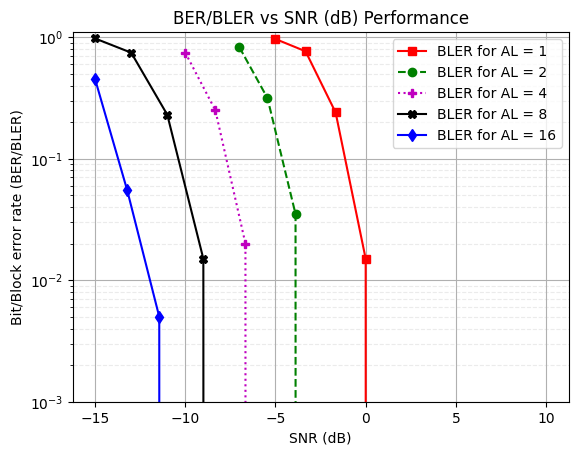

In [7]:
fig, ax = plt.subplots()

ls1 = ["-r", "--g", ":m", "-k","-b"]
ls2 = ["-r", "--g", ":m", "-k","-b"]
ls3 = ["-r", "--g", ":m", "-k","-b"]
markers = ["s", "o", "P", "X", "d"]


for al in range(AggLevel.size):
    
#     ax.semilogy(SNRdB[al], uncodedBER[al], ls1[al], marker = markers[al], label="uncodedBER-"+str(al))
    ax.semilogy(SNRdB[al], bler[al], ls3[al], marker = markers[al], label="BLER for AL = "+str(AggLevel[al]))    
#     ax.semilogy(SNRdB[al], codedBER[al], ls2[al], marker = markers[al], mec = "white", label="codedBER-"+str(al))

ax.legend(loc="best")

#     ax.set_xticks(SNRdB[r])
ytck = (0.1**(np.arange(1, 8))).repeat(9)*np.tile(np.arange(10, 1,-1), [7])
ytck = np.concatenate([[1],ytck])
ax.set_yticks(ytck, minor=True)
ax.set_yticks(0.1**(np.arange(0, 7)), minor=False)
ax.set_ylim([10**-3,1.1])

ax.grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax.grid(which = 'major', alpha = 1)

ax.set_xlabel("SNR (dB)")
ax.set_ylabel("Bit/Block error rate (BER/BLER)")
ax.set_title("BER/BLER vs SNR (dB) Performance")

plt.show()


## Reliability Performance: BER/BLER vs SNR for 20000 Batches

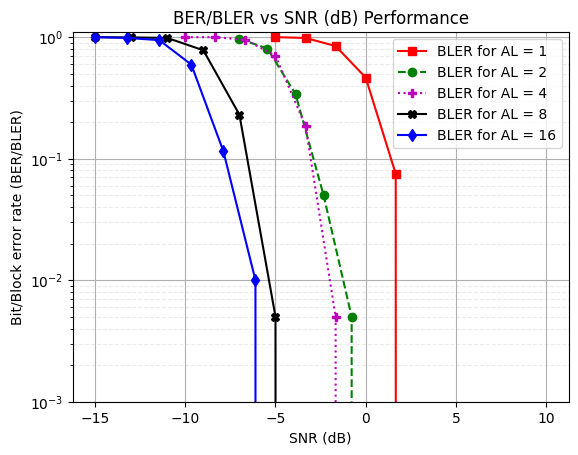

In [8]:
dB         = np.load("Databases/PDCCH_LLS.npz")

uncodedBER = dB["uncodedBER"]
codedBER   = dB["codedBER"]
bler       = dB["bler"]
SNRdB      = dB["SNRdB"]

fig, ax = plt.subplots()

ls1 = ["-r", "--g", ":m", "-k","-b"]
ls2 = ["-r", "--g", ":m", "-k","-b"]
ls3 = ["-r", "--g", ":m", "-k","-b"]
markers = ["s", "o", "P", "X", "d"]


for al in range(AggLevel.size):
    
#     ax.semilogy(SNRdB[al], uncodedBER[al], ls1[al], marker = markers[al], label="uncodedBER-"+str(al))
    ax.semilogy(SNRdB[al], bler[al], ls3[al], marker = markers[al], label="BLER for AL = "+str(AggLevel[al]))    
#     ax.semilogy(SNRdB[al], codedBER[al], ls2[al], marker = markers[al], mec = "white", label="codedBER-"+str(al))

ax.legend(loc="best")

#     ax.set_xticks(SNRdB[r])
ytck = (0.1**(np.arange(1, 8))).repeat(9)*np.tile(np.arange(10, 1,-1), [7])
ytck = np.concatenate([[1],ytck])
ax.set_yticks(ytck, minor=True)
ax.set_yticks(0.1**(np.arange(0, 7)), minor=False)
ax.set_ylim([10**-3,1.1])

ax.grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax.grid(which = 'major', alpha = 1)

ax.set_xlabel("SNR (dB)")
ax.set_ylabel("Bit/Block error rate (BER/BLER)")
ax.set_title("BER/BLER vs SNR (dB) Performance")

plt.show()